# Pneumonia Detection using CNN

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

## About Dataset

[Chest X-ray Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

## Get Training Data
The data is in form of images so we have to convert data into correct shaped array

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)    

## Divide the dataset into train, test and validation set

In [3]:
test = get_training_data('drive/MyDrive/Chest X-ray/chest_xray/test')

In [4]:
val = get_training_data('drive/MyDrive/Chest X-ray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [5]:
train = get_training_data('drive/MyDrive/Chest X-ray/chest_xray/train')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data Visualization and Preprocessing

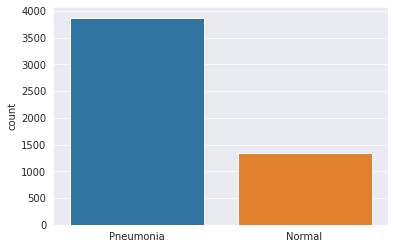

In [6]:
l = []
for i in train:
    if i[1] == 0:
        l.append('Pneumonia')
    else:
        l.append('Normal')

sns.set_style('darkgrid')        
sns.countplot(l)

The data seems imbalanced . To increase the number of training examples, we will use data augmentation in the future steps

## Preview the images from the training set of both categories

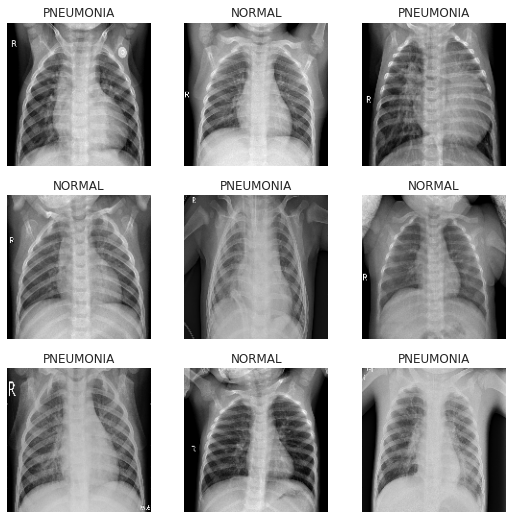

In [7]:
rows = 3
cols = 3
fig = plt.figure(figsize=(3*rows, 3*cols))

for i in range(1, rows*cols+1):
    if i%2:
        j = i
    else:
        j = -i
    fig.add_subplot(rows, cols, i)
    plt.imshow(train[j][0], cmap='gray')
    plt.title(str(labels[train[j][1]]), y=1)
    plt.axis('off')
plt.show()

## Split data into features and labels from train, test and validation set

In [8]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

## Normalize the data
We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [9]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

## Resize the image data
we have to resize the data because neural networks takes the fixed size images.

In [10]:
x_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

## Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Buliding Model
Model Using Keras
There are two different ways of defining the Model in Keras:

* Sequential Model
* Function API Functional API is used to build a more complicated Model such as for multi-output Models, directed acyclic graphs, or models with shared layers. I am using the Sequential Model in this notebook to keep things simple. In Sequential Model, you can add each layer sequentially.

<b>Description of Model:</b>

* 5 Convolutional Blocks Each block consists of 1 Conv2D layers with RelU activation layers. Then a MaxPool2D layer and some of Dropout Layers.

* Then Dense Layers and Output layer after Flatten layer.

* MaxPool2D layer is used to reduce the size of the image. Pool size (2,2) means reducing the image from (150,150) to (75,75). Reducing the features.

* Dropout layer drops the few activation nodes while training, which acts as regularization. Do let the model to over-fit.

* Output layer has 1 nodes with sigmoid activation.

In [12]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

## Define learning rate
The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.

* <b> ReduceLROnPlateau :</b> - Reduce learning rate when a metric has stopped improving.
Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2, verbose=1,
                                           factor=0.3, min_lr=0.000001)

## Training the model
model.fit() is used to train the model. It takes training data, batch_size, no of epochs, validation data. I am taking the epochs = 15 and batch size = 32. It will return the history of training, which later can be used to analyze the performance.

In [14]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                   epochs=15, validation_data=datagen.flow(x_val, y_val),
                   callbacks=[learning_rate_reduction])

Epoch 1/15
164/164 [==============================] - 45s 69ms/step - loss: 1.1854 - accuracy: 0.7984 - val_loss: 37.5493 - val_accuracy: 0.5000
Epoch 2/15
164/164 [==============================] - 10s 64ms/step - loss: 0.2799 - accuracy: 0.8987 - val_loss: 41.3325 - val_accuracy: 0.5000
Epoch 3/15
164/164 [==============================] - 11s 64ms/step - loss: 0.2281 - accuracy: 0.9195 - val_loss: 17.5092 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
164/164 [==============================] - 11s 65ms/step - loss: 0.1769 - accuracy: 0.9376 - val_loss: 4.3734 - val_accuracy: 0.5000
Epoch 5/15
164/164 [==============================] - 11s 64ms/step - loss: 0.1514 - accuracy: 0.9441 - val_loss: 0.2978 - val_accuracy: 0.8125
Epoch 6/15
164/164 [==============================] - 10s 64ms/step - loss: 0.1494 - accuracy: 0.9479 - val_loss: 1.1961 - val_accuracy: 0.6250
Epoch 7/15
164/164 [==============================] 

## Evaluate the model accuracy

In [15]:
print("Loss of model is : ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is : ", model.evaluate(x_test, y_test)[1]*100)

20/20 [==============================] - 0s 14ms/step - loss: 0.2852 - accuracy: 0.9231
Loss of model is :  0.28517603874206543
20/20 [==============================] - 0s 12ms/step - loss: 0.2852 - accuracy: 0.9231
Accuracy of the model is :  92.30769276618958


## Training Performance

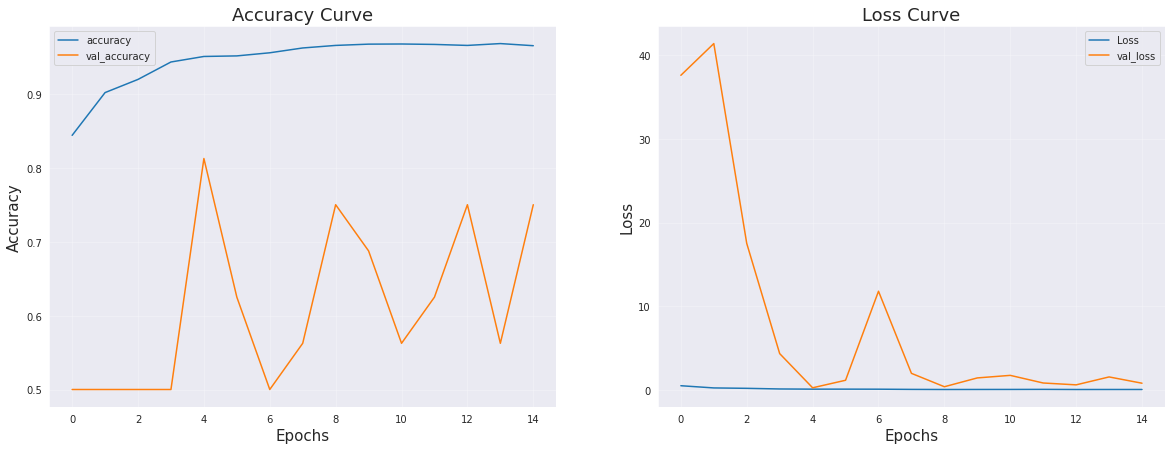

In [16]:
f = plt.figure(figsize=(20, 7))
#Adding subplot 1 (for accuracy)
f.add_subplot(121)

plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Adding subplot 2 (for loss)
f.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label='Loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')

plt.title("Loss Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

Now we can clearly see the fluctuation in validation accuracy but this fluctuation giving the good accuracy for testing set

## Prediction for X_test

In [17]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (class 0)', 'Normal (class 1)']))

                     precision    recall  f1-score   support

Pneumonia (class 0)       0.93      0.95      0.94       390
   Normal (class 1)       0.92      0.88      0.90       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



Our model giving the good recall percentage which shows the better model performance

## Confusion Matrix

In [19]:
cm = confusion_matrix(y_test, predictions)
cm

array([[371,  19],
       [ 29, 205]])

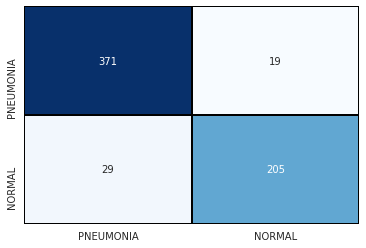

In [20]:
#plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels, cbar=False)

In [21]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [22]:
incorrect

array([  9,  51,  54,  61,  80,  94, 114, 136, 145, 152, 154, 163, 182,
       183, 227, 238, 244, 373, 379, 408, 452, 471, 498, 499, 500, 501,
       504, 505, 508, 516, 517, 518, 519, 520, 521, 523, 524, 525, 526,
       528, 530, 532, 533, 534, 544, 560, 575, 619])

## Plotting some result which correctly classified by model

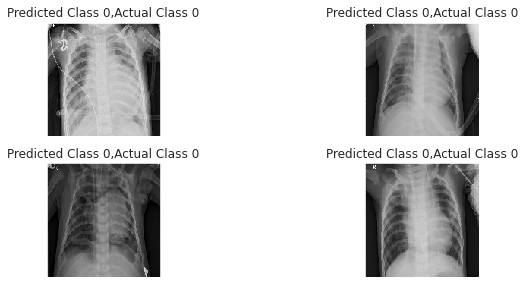

In [45]:
i = 1
rows = 3
cols = 2
plt.figure(figsize=(3*rows, 3*cols))
for c in correct[:4]:
    plt.subplot(rows,cols,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Results which are incorrectly classified by model

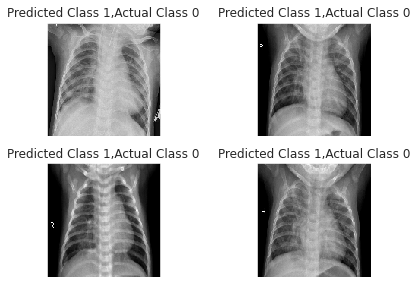

In [47]:
i = 0
rows = 2
cols = 2
plt.figure(figsize=(3*rows, 3*cols))
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## So this was my notebook for Pneumonia Detection
## Thank you